In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull
from tqdm import tqdm
import random
plt.style.use('ggplot')
import pickle
from sklearn import tree
from sklearn.tree import export_graphviz
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline
from sklearn.impute import SimpleImputer

In [3]:
def getAuc(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit,class_weight='balanced'),
                RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                ExtraTreesClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict_proba(X_test)
        #print(X_test,y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        if VERBOSE:
            print(auc)

        FPR=np.append(FPR,fpr)
        TPR=np.append(TPR,tpr)
    points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    hull = ConvexHull(points)
    x=np.argsort(points[hull.vertices,:][:,0])
    auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
    return auc,CLASSIFIERS


def saveFIG(filename='tmp.pdf',AXIS=False):
    '''
        save fig for publication
    '''
    import pylab as plt
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    if not AXIS:
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(filename,dpi=300, bbox_inches = 'tight',
                pad_inches = 0,transparent=False) 
    return

In [4]:
def getCoverage(model,verbose=True):
    '''
        return how many distinct items (questions)
        are used in the model set.
        This includes the set of questions being
        covered by all forms that may be 
        generated by the model set
    '''
    FS=[]
    for m in model:
        for count in range(len(m.estimators_)):
            clf=m.estimators_[count]
            fs=clf.tree_.feature[clf.tree_.feature>0]
            FS=np.array(list(set(np.append(FS,fs))))
    if verbose:
        print("Number of items used: ", FS.size)
    return FS

def getConfusion(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,CONFUSION={},VERBOSE=False, USE_ONLY=None,target_names = None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit),
                RandomForestClassifier(n_estimators=n_estimators,class_weight='balanced',
                                       max_depth=max_depth,min_samples_split=minsplit),
                ExtraTreesClassifier(n_estimators=n_estimators,class_weight='balanced',
                                     max_depth=max_depth,min_samples_split=minsplit),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        print(y_test,y_pred)
        cmat=confusion_matrix(y_test, y_pred)
        acc=accuracy_score(y_test, y_pred)
        
        CONFUSION[clf]=cmat
        
        if VERBOSE:
            print(classification_report(y_test, y_pred, target_names=target_names))
            print('Confusion MAtrix:\n', cmat)
            print(' ')
            print('Accuracy:', acc)

        
    return CONFUSION,acc

In [5]:
df=pd.read_csv('bsnip.csv',index_col=0)
df.head()

,project,Biotype,panss_p1,panss_p2,panss_p3,panss_p4,panss_p5,panss_p6,panss_p7,panss_n1,...,young_9,young_10,young_11,sfs_setotal,sfs_ictotal,sfs_ipcptotal,sfs_ipcctotal,sfs_retotal,sfs_prototal,sfs_oetotal
subject_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,2,4.0,3.0,4.0,1.0,3.0,2.0,1.0,4.0,...,0.0,1.0,2.0,9.0,8.0,27.0,NaN,25.0,45.0,5.0
4,1.0,5,3.0,1.0,3.0,1.0,2.0,2.0,1.0,3.0,...,0.0,0.0,0.0,7.0,8.0,19.0,NaN,13.0,9.0,4.0
53,1.0,2,4.0,3.0,5.0,2.0,1.0,3.0,1.0,5.0,...,0.0,1.5,0.0,10.0,4.0,24.0,31.0,10.0,17.0,0.0
73,1.0,2,6.0,5.0,6.0,4.0,5.0,6.0,6.0,1.0,...,2.0,1.0,4.0,7.0,7.0,21.0,18.0,15.0,11.0,10.0
78,1.0,1,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,9.0,9.0,36.0,39.0,13.0,12.0,1.0


In [85]:
# 3 is HC
df.Biotype.value_counts()

1    595
5    500
2    446
Name: Biotype, dtype: int64

In [86]:
#df=df[df['Biotype']==3]
df=df.dropna()
df0=df

In [87]:
#df=df0[df0.Biotype.isin([1,5])]
df=df0
X=df.iloc[:,2:].values
y=df.Biotype.values#.astype(str)
y5=[(int(x)==5)+0 for x in y ]
y1=[(int(x)==1)+0 for x in y ]
y2=[(int(x)==2)+0 for x in y ]
X.shape

(1541, 58)

In [153]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2)
y5=[(int(x)==5)+0 for x in y_train_ ]
y1=[(int(x)==1)+0 for x in y_train_ ]
y2=[(int(x)==2)+0 for x in y_train_ ]


In [154]:
ACC=[]
CLFh={}
for run in tqdm(np.arange(500)):
    auc,CLFS=getAuc(X_train_,y5,test_size=0.2,max_depth=10,n_estimators=2,
               minsplit=2,VERBOSE=False, USE_ONLY=[2])
    ACC=np.append(ACC,auc)
    if auc > 0.75:
        CLFh[auc]=CLFS
#sns.distplot(ACC)
print(np.median(ACC))
CLFstar5=CLFh[np.array([k for k in CLFh.keys()]).max()][0]

100%|██████████| 500/500 [00:03<00:00, 132.26it/s]

0.7426079109542696


In [155]:
ACC=[]
CLFh={}
for run in tqdm(np.arange(500)):
    auc,CLFS=getAuc(X_train_,y1,test_size=0.2,max_depth=10,n_estimators=2,
               minsplit=2,VERBOSE=False, USE_ONLY=[2])
    ACC=np.append(ACC,auc)
    if auc > 0.65:
        CLFh[auc]=CLFS
#sns.distplot(ACC)
print(np.median(ACC))
CLFstar1=CLFh[np.array([k for k in CLFh.keys()]).max()][0]

100%|██████████| 500/500 [00:03<00:00, 131.32it/s]

0.6965697599794635


In [156]:
ACC=[]
CLFh={}
for run in tqdm(np.arange(500)):
    auc,CLFS=getAuc(X_train_,y2,test_size=0.2,max_depth=10,n_estimators=2,
               minsplit=2,VERBOSE=False, USE_ONLY=[2])
    ACC=np.append(ACC,auc)
    if auc > 0.75:
        CLFh[auc]=CLFS
#sns.distplot(ACC)
print(np.median(ACC))
CLFstar2=CLFh[np.array([k for k in CLFh.keys()]).max()][0]

100%|██████████| 500/500 [00:03<00:00, 134.36it/s]

0.6701701040014101


In [174]:
y_pred5p=CLFstar5.predict_proba(X_test_)
y_pred1p=CLFstar1.predict_proba(X_test_)
y_pred2p=CLFstar2.predict_proba(X_test_)

Y=[]
a=1
for (i,j,k) in zip(y_pred1p[:,1]**a,y_pred5p[:,1]**a,y_pred2p[:,1]**a):
    idx=np.argmax([i,j,k])
    #print(idx)
    if idx == 0:
        l=1
        Y=np.append(Y,l)   
        continue
    if idx == 1:
        l=5
        Y=np.append(Y,l)   
        continue
    if idx == 2:
        l=2
        Y=np.append(Y,l)   
        continue
print(len(Y))

from sklearn.metrics import accuracy_score
ACC=accuracy_score(y_test_, Y)
from sklearn.metrics import confusion_matrix
C=confusion_matrix(y_test_, Y)
row_sums = C.sum(axis=1)
C1 = C / row_sums[:, np.newaxis]
print(ACC,C1)

309
0.5307443365695793 [[0.65346535 0.1980198  0.14851485]
 [0.28181818 0.39090909 0.32727273]
 [0.32653061 0.1122449  0.56122449]]


In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
y_pred5p=CLFstar5.predict_proba(X_test)
y_pred1p=CLFstar1.predict_proba(X_test)
y_pred2p=CLFstar2.predict_proba(X_test)

Y=[]
a=-.3
for (i,j,k) in zip(y_pred1p[:,1]**a,y_pred5p[:,1]**a,y_pred2p[:,1]**a):
    idx=np.argmax([i,j,k])
    #print(idx)
    if idx == 0:
        l=1
        Y=np.append(Y,l)   
        continue
    if idx == 1:
        l=5
        Y=np.append(Y,l)   
        continue
    if idx == 2:
        l=2
        Y=np.append(Y,l)   
        continue
print(len(Y))

from sklearn.metrics import accuracy_score
ACC=accuracy_score(y_test, Y)
from sklearn.metrics import confusion_matrix
C=confusion_matrix(y_test, Y)
row_sums = C.sum(axis=1)
C1 = C / row_sums[:, np.newaxis]
print(ACC,C1)

771
0.06874189364461739 [[0.05226481 0.34494774 0.60278746]
 [0.456621   0.08219178 0.46118721]
 [0.53584906 0.38867925 0.0754717 ]]


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in power
  


In [172]:
for runs in np.arange(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    y_pred5p=CLFstar5.predict_proba(X_test)
    y_pred1p=CLFstar1.predict_proba(X_test)
    y_pred2p=CLFstar2.predict_proba(X_test)

    Y=[]
    a=1
    for (i,j,k) in zip(y_pred1p[:,1]**a,y_pred5p[:,1]**a,y_pred2p[:,1]**a):
        idx=np.argmax([i,j,k])
        #print(idx)
        if idx == 0:
            l=1
            Y=np.append(Y,l)   
            continue
        if idx == 1:
            l=5
            Y=np.append(Y,l)   
            continue
        if idx == 2:
            l=2
            Y=np.append(Y,l)   
            continue

    from sklearn.metrics import accuracy_score
    ACC=accuracy_score(y_test, Y)
    from sklearn.metrics import confusion_matrix
    C=confusion_matrix(y_test, Y)
    row_sums = C.sum(axis=1)
    C1 = C / row_sums[:, np.newaxis]
    print(ACC,C1)

0.8058252427184466 [[0.87155963 0.05504587 0.0733945 ]
 [0.14736842 0.64210526 0.21052632]
 [0.0952381  0.01904762 0.88571429]]
0.8187702265372169 [[0.83185841 0.09734513 0.07079646]
 [0.06593407 0.76923077 0.16483516]
 [0.1047619  0.04761905 0.84761905]]
0.8155339805825242 [[0.8559322  0.06779661 0.07627119]
 [0.13483146 0.74157303 0.12359551]
 [0.1372549  0.02941176 0.83333333]]
0.8414239482200647 [[0.90983607 0.04918033 0.04098361]
 [0.1011236  0.76404494 0.13483146]
 [0.12244898 0.05102041 0.82653061]]
0.8414239482200647 [[0.87704918 0.06557377 0.05737705]
 [0.10227273 0.79545455 0.10227273]
 [0.14141414 0.02020202 0.83838384]]
0.8122977346278317 [[0.83606557 0.08196721 0.08196721]
 [0.11627907 0.69767442 0.18604651]
 [0.08910891 0.02970297 0.88118812]]
0.8090614886731392 [[0.86885246 0.05737705 0.07377049]
 [0.11956522 0.68478261 0.19565217]
 [0.08421053 0.06315789 0.85263158]]
0.8220064724919094 [[0.864      0.064      0.072     ]
 [0.12903226 0.74193548 0.12903226]
 [0.08791209 

0.8220064724919094 [[0.88392857 0.03571429 0.08035714]
 [0.13483146 0.69662921 0.16853933]
 [0.09259259 0.0462963  0.86111111]]
0.7799352750809061 [[0.84615385 0.06837607 0.08547009]
 [0.09782609 0.7173913  0.18478261]
 [0.19       0.05       0.76      ]]
0.8252427184466019 [[0.859375   0.0859375  0.0546875 ]
 [0.08536585 0.74390244 0.17073171]
 [0.09090909 0.06060606 0.84848485]]
0.8090614886731392 [[0.86607143 0.05357143 0.08035714]
 [0.12903226 0.74193548 0.12903226]
 [0.125      0.06730769 0.80769231]]
0.7961165048543689 [[0.82352941 0.06722689 0.1092437 ]
 [0.14634146 0.67073171 0.18292683]
 [0.07407407 0.06481481 0.86111111]]
0.8122977346278317 [[0.84552846 0.08130081 0.07317073]
 [0.12765957 0.71276596 0.15957447]
 [0.10869565 0.02173913 0.86956522]]
0.8349514563106796 [[0.88095238 0.04761905 0.07142857]
 [0.15584416 0.76623377 0.07792208]
 [0.11320755 0.05660377 0.83018868]]
0.8122977346278317 [[0.86290323 0.07258065 0.06451613]
 [0.13580247 0.67901235 0.18518519]
 [0.08653846 

100%|██████████| 500/500 [00:02<00:00, 170.57it/s]


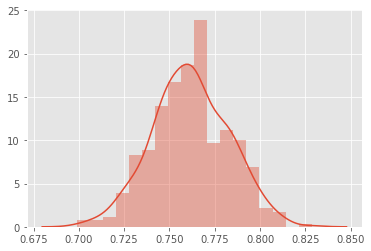

In [141]:
RUNS=500
A=[]
for run in tqdm(np.arange(RUNS)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    y_pred5=CLFstar5.predict(X_test)
    y_pred1=CLFstar1.predict(X_test)
    Y=[]
    for (i,j) in zip(y_pred1,y_pred5):
        if i==0 and j==1:
            k=5
        if i==1 and j==0:
            k=1
        if i==0 and j==0:
            k=2
        if i==1 and j==1:
            k=1
        Y=np.append(Y,k)   
    A=np.append(A,accuracy_score(y_test, Y))
sns.distplot(A)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_pred5=CLFstar5.predict(X)
y_pred1=CLFstar1.predict(X)
Y=[]
for (i,j) in zip(y_pred1,y_pred5):
    if i==0 and j==1:
        k=5
    if i==1 and j==0:
        k=1
    if i==0 and j==0:
        k=2
    if i==1 and j==1:
        k=1
    Y=np.append(Y,k)   
ACC=accuracy_score(y_test, Y)
from sklearn.metrics import confusion_matrix
C=confusion_matrix(y_test, Y)

In [150]:
C

array([[116,   7,   5],
       [ 12,  56,  12],
       [ 16,   8,  77]])

In [68]:
def getCoverage(model,verbose=True):
    '''
        return how many distinct items (questions)
        are used in the model set.
        This includes the set of questions being
        covered by all forms that may be 
        generated by the model set
    '''
    FS=[]
    for m in model:
        for count in range(len(m.estimators_)):
            clf=m.estimators_[count]
            fs=clf.tree_.feature[clf.tree_.feature>0]
            FS=np.array(list(set(np.append(FS,fs))))
    if verbose:
        print("Number of items used: ", FS.size)
    return FS

In [107]:
getCoverage(CLFstar1)

AttributeError: 'ExtraTreeClassifier' object has no attribute 'estimators_'

In [ ]:
A=CLFstar1.estimators_[0]
a=' '.join(list(A.tree_.feature.astype(str))).split('-2')
b=[len(x.split()) for x in a if x != ' ']
np.array(b).sum()*(10/2**9)
#len(list(set(A.tree_.feature[A.tree_.feature>0])))

In [201]:
def getAvLen(clf):
    s=0
    for e in clf.estimators_:
        a=' '.join(list(e.tree_.feature.astype(str))).split('-2')
        b=[len(x.split()) for x in a if x != ' ']
        s=s+np.array(b).sum()*(10/2**9)
    return s

In [202]:
getAvLen(CLFstar1)

8.2421875

In [203]:
getAvLen(CLFstar5)

6.73828125

In [205]:
getAvLen(CLFstar2)+getAvLen(CLFstar5)

12.2265625

In [196]:
def drawTrees(model):
    '''
        draw the estimators (trees)
        in a single model
    '''
    N=len(model.estimators_)

    for count in range(N):
        estimator = model.estimators_[count]

        export_graphviz(estimator, out_file='tmptree.dot', 
                        #feature_names = iris.feature_names,
                        #class_names = iris.target_names,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True)

        from subprocess import call
        call(['dot', '-Tpng', 'tmptree.dot', '-o', 'tmptree'+str(count)+'.png', '-Gdpi=600'])
        from IPython.display import Image
        Image(filename = 'tmptree'+str(count)+'.png') 

In [120]:
drawTrees(CLFstar5)

In [ ]:
from scipy import interpolate
from scipy.interpolate import interp1d
auc_=[]
ROC={}
fpr_ = np.linspace(0, 1, num=20, endpoint=True)
for run in np.arange(1000):
    clf=CLFstar
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    y_pred=clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
    f = interp1d(fpr, tpr)
    auc_=np.append(auc_,metrics.auc(fpr_, f(fpr_)))
    ROC[metrics.auc(fpr, tpr)]={'fpr':fpr_,'tpr':f(fpr_)}
sns.distplot(auc_)
auc_.mean()